In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorboard import summary as summary_lib
from tensorboard import plugins as plugins_lib

import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline




In [2]:
data_dir_1 = '/Users/derekwang/Work/Stock_out/Data/STOCK_OUT_master_training.csv'
data_dir_2 = '/Users/derekwang/Work/Stock_out/Data/STOCK_OUT_master_training_0219.csv'
data_dir_3 = '/Users/derekwang/Work/Stock_out/Data/STOCK_OUT_master_training_0226.csv'


model_dir = '/Users/derekwang/Work/Stock_out/tuned_model'

In [5]:
data_raw_1 = pd.read_csv(data_dir_1, sep=',', header=0)
#data_raw['TRUCK_CONSTRAINT'] = data_raw.TRUCK_CONSTRAINT.astype('int64')
data_raw_2 = pd.read_csv(data_dir_2, sep=',', header=0)
data_raw = pd.concat([data_raw_1, data_raw_2])
data_raw_3 = pd.read_csv(data_dir_3, sep=',', header=0)


data_clean = data_raw # outlier_remove(data_raw)
data_clean.head()

,LOC_ID,ITEM_ID,CAL_DT,STR_INV_STR_VOL_LVL_CD,STR_INV_STRD_VOL_LVL_CD,STR_INV_STRC_VOL_LVL_CD,STR_INV_STRSC_VOL_LVL_CD,ITEM_VLCTY_CD,OH_QTY,OO_QTY,...,REV_TM_DAYS_CNT,SFTY_STK_QTY,SVC_LVL_VAL,ASL_OSL_VAL,ADJ_ASW_QTY,CAR_PARM_CURR_RETL_AMT,WK1_FCST,WK2_FCST,WK3_FCST,SIMPL_OOS_IND
0,2682,6040770,2018-01-21,2,1,1,2,2,0.0,15,...,7,18.351539,99.70,77.08,4.490,13.27,5.155,3.969,3.513,1
1,359,5983727,2018-01-21,2,1,2,2,3,11.0,0,...,7,12.731372,95.00,98.77,2.890,1.98,5.066,5.114,5.018,1
2,1262,719971,2018-01-21,2,1,2,2,1,13.0,90,...,4,53.837502,88.68,97.72,44.697,3.48,53.784,52.318,50.330,1
3,1366,2601810,2018-01-21,2,1,1,2,2,40.0,0,...,7,25.809154,99.30,99.90,12.470,0.96,12.796,12.548,11.958,0
4,755,5218758,2018-01-21,1,1,1,1,1,121.0,30,...,7,63.625968,99.80,100.00,25.311,19.98,29.909,29.334,28.183,0


In [6]:
numerical_columns = []
for x in data_clean.columns[3:-1]:
    numerical_columns.append(x)
        
# numerical_columns

In [7]:
def feats_norm(df, numerical_columns):
    norm_df = df.copy()
    normalizer = pd.DataFrame(columns = numerical_columns, index = ['mean', 'std'])
    for col in numerical_columns:
        mean = norm_df[col].mean()
        std = norm_df[col].std()
        normalizer.loc['mean', col] = mean
        normalizer.loc['std', col] = std
        norm_df[col] = (norm_df[col] - mean) / (std + 10.0** -6)
    return norm_df, normalizer

def feats_norm_with_normalizer(df, normalizer, numerical_columns):
    norm_df = df.copy()
    for col in numerical_columns:
        mean = normalizer.loc['mean', col]
        std = normalizer.loc['std', col]
        norm_df[col] = (norm_df[col] - mean) / (std + 10.0** -6)
    return norm_df

data_norm, normalizer = feats_norm(data_clean, numerical_columns)
data_norm.describe()   

,LOC_ID,ITEM_ID,STR_INV_STR_VOL_LVL_CD,STR_INV_STRD_VOL_LVL_CD,STR_INV_STRC_VOL_LVL_CD,STR_INV_STRSC_VOL_LVL_CD,ITEM_VLCTY_CD,OH_QTY,OO_QTY,SELL_UOM_QTY,...,REV_TM_DAYS_CNT,SFTY_STK_QTY,SVC_LVL_VAL,ASL_OSL_VAL,ADJ_ASW_QTY,CAR_PARM_CURR_RETL_AMT,WK1_FCST,WK2_FCST,WK3_FCST,SIMPL_OOS_IND
count,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6774612.0,...,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06,6.774612e+06
mean,1.445738e+03,2.173281e+06,-6.900473e-17,3.060910e-17,-3.023320e-16,3.944278e-16,-1.017618e-16,-2.538340e-16,3.021291e-18,0.0,...,9.118123e-17,-3.060239e-16,6.367096e-15,4.308214e-15,1.379229e-16,-9.229718e-17,3.213620e-18,6.799182e-17,-7.768407e-17,1.825885e-01
std,9.158019e+02,2.308487e+06,9.999992e-01,9.999992e-01,9.999992e-01,9.999992e-01,9.999990e-01,1.000000e+00,9.999999e-01,0.0,...,9.999997e-01,1.000000e+00,9.999998e-01,9.999999e-01,1.000000e+00,1.000000e+00,9.999999e-01,9.999999e-01,9.999999e-01,3.863288e-01
min,1.700000e+01,2.400000e+01,-2.251255e+00,-2.296076e+00,-2.369479e+00,-2.435781e+00,-3.882870e+00,-3.096820e-01,-6.063261e-02,0.0,...,-1.421987e+00,-3.119710e-01,-7.962545e+00,-6.416418e+00,-9.662867e-02,-2.864997e-01,-1.118161e-01,-1.077516e-01,-1.060960e-01,0.000000e+00
25%,7.680000e+02,4.024470e+05,-7.294982e-01,-7.715591e-01,-8.360628e-01,-8.965771e-01,-9.695636e-01,-2.305036e-01,-6.063261e-02,0.0,...,-5.335190e-01,-2.663268e-01,-1.602985e-01,3.043645e-01,-8.499893e-02,-2.437158e-01,-9.964435e-02,-9.587316e-02,-9.443438e-02,0.000000e+00
50%,1.293000e+03,7.887870e+05,3.138031e-02,-9.300871e-03,-6.935478e-02,-1.269751e-01,1.538371e-03,-1.711198e-01,-6.063261e-02,0.0,...,3.549494e-01,-1.839537e-01,4.465428e-01,3.043645e-01,-7.195806e-02,-1.993342e-01,-8.209889e-02,-7.883290e-02,-7.759645e-02,0.000000e+00
75%,2.074000e+03,3.836307e+06,7.922588e-01,7.529574e-01,6.973533e-01,6.426268e-01,9.726404e-01,-3.255755e-02,-6.063261e-02,0.0,...,3.549494e-01,-2.451115e-02,5.679111e-01,3.043645e-01,-3.526843e-02,-6.618944e-02,-3.852657e-02,-3.654320e-02,-3.576938e-02,0.000000e+00
max,2.627600e+04,7.327038e+06,1.553137e+00,1.515216e+00,1.464061e+00,1.412229e+00,1.943742e+00,3.420578e+02,6.372230e+02,0.0,...,7.166540e+00,3.575166e+02,6.719411e-01,3.043645e-01,1.026490e+03,8.314069e+01,9.472990e+02,9.430830e+02,9.598416e+02,1.000000e+00


In [8]:
def rand_datasets(df, train_pct):
    rand_num = np.random.rand(len(df))
    
    df_train = df[rand_num < train_pct]
    df_cross = df[rand_num >= train_pct]
    
    return df_train, df_cross

train, test = rand_datasets(data_norm, 0.80)

train_x, train_y = train.iloc[:,3:-1], train.pop('SIMPL_OOS_IND')
test_x, test_y = test.iloc[:,3:-1], test.pop('SIMPL_OOS_IND')

In [9]:
def model_fn(features, labels, mode, params):
    net = tf.feature_column.input_layer(features, params['feature_columns'])
    
    for units in params['hidden_units']:
        net = tf.layers.dense(net, units=units, activation=tf.nn.relu)
        
    logits = tf.layers.dense(net, params['n_classes'], activation=None)
    
    predicted_classes = tf.argmax(logits, 1)
    predicted_probabilities = tf.nn.softmax(logits)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    l2_regularizer = tf.contrib.layers.l2_regularizer(scale = params['regularization_rate'])
    l2_penalty = tf.contrib.layers.apply_regularization(
                                                    regularizer = l2_regularizer,
                                                    weights_list = tf.trainable_variables())
    
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, logits=logits)
        )
    
    regularized_loss = loss + l2_penalty
    
    
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('regularized_loss', regularized_loss)
    
    accuracy = tf.metrics.accuracy(labels = labels,
                                   predictions=predicted_classes,
                                  name='acc_op')
    
    precision = tf.contrib.metrics.streaming_precision(predictions = predicted_classes, 
                                                       labels = labels)
    
    recall = tf.contrib.metrics.streaming_recall(predictions = predicted_classes, 
                                                       labels = labels)
    
    pr_auc = tf.contrib.metrics.streaming_auc(predictions=predicted_probabilities[:,1], 
                                             labels = labels,
                                             curve = 'PR',
                                             num_thresholds = 1000)
    

    pr_curve = summary_lib.pr_curve_streaming_op(
              name="pr_curve",
              labels=labels,
              predictions=predicted_probabilities[:,1]
      )


    
    metrics = {'accuracy': accuracy,
               'precision': precision,
               'recall': recall,
               'pr_auc': pr_auc,
#                "pr_curve": pr_curve
              }
    
    tf.summary.scalar('accuracy', accuracy[1])
    tf.summary.scalar('precision', precision[1])
    tf.summary.scalar('recall', recall[1])
    tf.summary.scalar('pr_auc', pr_auc[1])
    
    

    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss= regularized_loss, eval_metric_ops=metrics)
    
    assert mode == tf.estimator.ModeKeys.TRAIN
    
    optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
    train_op = optimizer.minimize(loss=regularized_loss, global_step = tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=regularized_loss, train_op=train_op)


In [10]:
def train_input_fn(features, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    return dataset

def eval_input_fn(features, labels, batch_size):
    features=dict(features)
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)
    
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)
    return dataset

In [11]:
my_feature_columns = []
for key in train_x.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

my_feature_columns

[_NumericColumn(key='STR_INV_STR_VOL_LVL_CD', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='STR_INV_STRD_VOL_LVL_CD', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='STR_INV_STRC_VOL_LVL_CD', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='STR_INV_STRSC_VOL_LVL_CD', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='ITEM_VLCTY_CD', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='OH_QTY', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='OO_QTY', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='SELL_UOM_QTY', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='BUY_UOM_QTY', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _Num

In [12]:
classifier = tf.estimator.Estimator(
    model_fn = model_fn, 
    model_dir = model_dir,
    params={
        'feature_columns': my_feature_columns,
        'hidden_units': [512, 256, 16],
        'n_classes': 2,
        'learning_rate': 1e-5,
        'regularization_rate': 2e-3,
    })

In [13]:
%%time
classifier.train(
    input_fn=lambda:train_input_fn(train_x, train_y, 400),
    steps = 5e4)

Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.


CPU times: user 36min 47s, sys: 1min 55s, total: 38min 43s
Wall time: 19min 25s


In [14]:
eval_result = classifier.evaluate(
    input_fn =lambda:eval_input_fn(test_x, test_y, 200))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
print('\nTest set precision: {precision:0.3f}\n'.format(**eval_result))
print('\nTest set recall: {recall:0.3f}\n'.format(**eval_result))
print('\nTest set pr_auc: {pr_auc:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.829


Test set precision: 0.695


Test set recall: 0.114


Test set pr_auc: 0.398



In [15]:
final_test_df = feats_norm_with_normalizer(data_raw_3, normalizer, numerical_columns)
final_test_df.describe()

,LOC_ID,ITEM_ID,STR_INV_STR_VOL_LVL_CD,STR_INV_STRD_VOL_LVL_CD,STR_INV_STRC_VOL_LVL_CD,STR_INV_STRSC_VOL_LVL_CD,ITEM_VLCTY_CD,OH_QTY,OO_QTY,SELL_UOM_QTY,...,REV_TM_DAYS_CNT,SFTY_STK_QTY,SVC_LVL_VAL,ASL_OSL_VAL,ADJ_ASW_QTY,CAR_PARM_CURR_RETL_AMT,WK1_FCST,WK2_FCST,WK3_FCST,SIMPL_OOS_IND
count,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3430405.0,...,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06,3.430405e+06
mean,1.442048e+03,2.206970e+06,-1.174343e-03,-3.999455e-04,4.999455e-04,-1.305660e-06,3.106148e-02,2.080491e-03,9.265886e-03,0.0,...,-3.629808e-04,1.956913e-03,1.814881e-02,3.730060e-03,1.301392e-03,9.297057e-03,2.609083e-03,6.955833e-03,5.427319e-03,1.848709e-01
std,9.288854e+02,2.331313e+06,1.002512e+00,1.001685e+00,1.000717e+00,1.000001e+00,1.023022e+00,9.757393e-01,1.608909e+00,0.0,...,1.015786e+00,9.835470e-01,9.707368e-01,9.892020e-01,9.042711e-01,1.025343e+00,1.175354e+00,1.157147e+00,1.115492e+00,3.881928e-01
min,1.700000e+01,4.100000e+01,-2.251255e+00,-2.296076e+00,-2.369479e+00,-2.435781e+00,-3.882870e+00,-3.096820e-01,-6.063261e-02,0.0,...,-1.421987e+00,-3.119710e-01,-7.927868e+00,-6.416418e+00,-9.667733e-02,-2.864997e-01,-1.118161e-01,-1.077516e-01,-1.060960e-01,0.000000e+00
25%,7.650000e+02,4.049050e+05,-7.294982e-01,-7.715591e-01,-8.360628e-01,-8.965771e-01,-9.695636e-01,-2.305036e-01,-6.063261e-02,0.0,...,-8.296752e-01,-2.672446e-01,-1.602985e-01,3.043645e-01,-8.509625e-02,-2.437158e-01,-9.964435e-02,-9.543783e-02,-9.401790e-02,0.000000e+00
50%,1.292000e+03,7.920050e+05,3.138031e-02,-9.300871e-03,-6.935478e-02,-1.269751e-01,1.538371e-03,-1.711198e-01,-6.063261e-02,0.0,...,3.549494e-01,-1.837220e-01,4.465428e-01,3.043645e-01,-7.186074e-02,-1.992455e-01,-8.209889e-02,-7.765128e-02,-7.658499e-02,0.000000e+00
75%,2.067000e+03,3.895479e+06,7.922588e-01,7.529574e-01,6.973533e-01,6.426268e-01,9.726404e-01,-3.255755e-02,-6.063261e-02,0.0,...,3.549494e-01,-2.358807e-02,5.679111e-01,3.043645e-01,-3.414925e-02,-6.618944e-02,-3.755542e-02,-3.250080e-02,-3.225900e-02,0.000000e+00
max,2.627600e+04,7.358761e+06,1.553137e+00,1.515216e+00,1.464061e+00,1.412229e+00,1.943742e+00,2.430848e+02,1.249515e+03,0.0,...,7.166540e+00,2.555585e+02,6.719411e-01,3.043645e-01,7.748817e+02,7.067834e+01,1.052247e+03,1.002712e+03,9.430069e+02,1.000000e+00


In [16]:
final_test_x, final_test_y = final_test_df.iloc[:,3:-1], final_test_df.pop('SIMPL_OOS_IND')


In [17]:
eval_result = classifier.evaluate(
    input_fn =lambda:eval_input_fn(final_test_x, final_test_y, 200))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))
print('\nTest set precision: {precision:0.3f}\n'.format(**eval_result))
print('\nTest set recall: {recall:0.3f}\n'.format(**eval_result))
print('\nTest set pr_auc: {pr_auc:0.3f}\n'.format(**eval_result))


Test set accuracy: 0.827


Test set precision: 0.709


Test set recall: 0.110


Test set pr_auc: 0.406



In [18]:
predictions = classifier.predict(
    input_fn =lambda:eval_input_fn(features=final_test_x, labels=None, batch_size = 200))

In [19]:
predicted_probablities = np.array([x['probabilities'] for x in predictions])
predicted_probablities

array([[0.8461467 , 0.15385324],
       [0.89243275, 0.10756725],
       [0.9972909 , 0.00270911],
       ...,
       [0.95980376, 0.04019623],
       [0.909312  , 0.09068798],
       [0.88932276, 0.11067723]], dtype=float32)

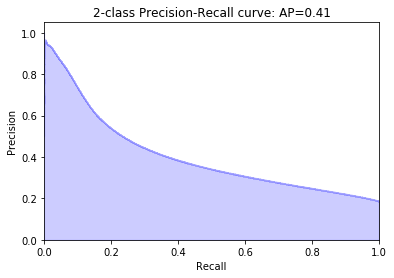

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(final_test_y.values, predicted_probablities[:,1])
precision, recall, thresholds = precision_recall_curve(final_test_y.values, predicted_probablities[:,1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [21]:
result = pd.DataFrame(columns = ['precision', 'recall', 'threshold'])
result['precision'] = precision
result['recall'] = recall
zero = np.array([0])
result['threshold'] = np.concatenate((zero, thresholds))




In [25]:
result[(result.precision > 0.9)].head()

,precision,recall,threshold
2938992,0.900017,0.034109,0.851504
2938993,0.900012,0.034107,0.851509
2938994,0.900008,0.034105,0.851536
2938995,0.900004,0.034104,0.851537
2938999,0.900029,0.034099,0.851548


In [26]:
sum(predicted_probablities[:,1] > 0.8515)

24039